# DiploDatos Kaggle Competition

Presentamos un código creado como ejemplo de base para la competición.

Deben:

- Explorar los datos y aprender de ellos.
- Probar diferentes modelos y ver cuáles ajustan mejor dado los datos.
- **Obtener una accuracy mejor que la que se presenta en este ejemplo.**
- Tratar de obtener la accuracy más alta posible!
- Discutir la elección de modelo.

El análisis exploratorio y el preprocesamiento de los datos queda a libertad de cada grupo y no deben quedarse con este simple ejemplo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score


## Leer el dataset

### Train

Cargamos los datos de entrenamiento que vamos a utilizar para generar nuestro modelo. 

In [2]:
train_df = pd.read_csv('diabetes_prediction_dataset_train-labeled.csv')
print(train_df.shape)
print(train_df.describe())

(95000, 10)
             patient           age  hypertension  heart_disease           bmi  \
count   95000.000000  95000.000000  95000.000000   95000.000000  95000.000000   
mean    50016.501389     41.935269      0.075074       0.039463     27.320879   
std     28868.357071     22.514788      0.263512       0.194695      6.626335   
min         1.000000      0.080000      0.000000       0.000000     10.010000   
25%     25021.750000     24.000000      0.000000       0.000000     23.650000   
50%     50024.000000     43.000000      0.000000       0.000000     27.320000   
75%     75024.250000     60.000000      0.000000       0.000000     29.580000   
max    100000.000000     80.000000      1.000000       1.000000     95.690000   

        HbA1c_level  blood_glucose_level      diabetes  
count  95000.000000         95000.000000  95000.000000  
mean       5.527659           138.070537      0.085074  
std        1.070261            40.739962      0.278993  
min        3.500000           

In [3]:
train_df.head()

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,20432,Male,4.0,0,0,never,19.28,3.5,155,0
1,49682,Female,50.0,0,0,former,27.32,5.7,159,0
2,73886,Female,43.0,0,0,never,21.54,4.5,145,0
3,53144,Male,64.0,0,0,current,28.22,6.0,130,0
4,98507,Male,10.0,0,0,No Info,15.46,6.1,140,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient              95000 non-null  int64  
 1   gender               95000 non-null  object 
 2   age                  95000 non-null  float64
 3   hypertension         95000 non-null  int64  
 4   heart_disease        95000 non-null  int64  
 5   smoking_history      95000 non-null  object 
 6   bmi                  95000 non-null  float64
 7   HbA1c_level          95000 non-null  float64
 8   blood_glucose_level  95000 non-null  int64  
 9   diabetes             95000 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 7.2+ MB


La columna ***`diabetes`*** es la columna que debemos predecir. En el dataset de Test esta columna tiene valores nulos.

### Test

Cargamos los datos de test. Estos datos son los que van a utilizar para predecir si las personas tienen diabetes y generar alrchivo `submision.csv` para utilizar en la competencia de Kaggle.

In [5]:
test_df = pd.read_csv('diabetes_prediction_dataset_test.csv')
print(test_df.shape)
print(test_df.describe())

(5000, 10)
            patient          age  hypertension  heart_disease          bmi  \
count   5000.000000  5000.000000   5000.000000    5000.000000  5000.000000   
mean   49696.473600    40.947016      0.070600       0.038600    27.318644   
std    28855.568156    22.537466      0.256181       0.192659     6.832943   
min        7.000000     0.160000      0.000000       0.000000    10.620000   
25%    24720.750000    23.000000      0.000000       0.000000    23.410000   
50%    49522.500000    41.000000      0.000000       0.000000    27.320000   
75%    74686.000000    59.000000      0.000000       0.000000    29.632500   
max    99970.000000    80.000000      1.000000       1.000000    88.760000   

       HbA1c_level  blood_glucose_level  diabetes  
count  5000.000000          5000.000000       0.0  
mean      5.524620           137.821000       NaN  
std       1.078559            40.101933       NaN  
min       3.500000            80.000000       NaN  
25%       4.800000        

In [6]:
test_df.head()

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,49267,Male,53.0,0,0,never,31.99,4.5,126,NaN
1,82280,Female,22.0,0,0,never,25.96,6.6,130,NaN
2,33216,Female,37.0,0,0,never,22.24,6.2,126,NaN
3,94551,Female,29.0,0,0,not current,31.01,5.0,80,NaN
4,43760,Male,30.0,0,0,ever,28.66,6.6,100,NaN


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient              5000 non-null   int64  
 1   gender               5000 non-null   object 
 2   age                  5000 non-null   float64
 3   hypertension         5000 non-null   int64  
 4   heart_disease        5000 non-null   int64  
 5   smoking_history      5000 non-null   object 
 6   bmi                  5000 non-null   float64
 7   HbA1c_level          5000 non-null   float64
 8   blood_glucose_level  5000 non-null   int64  
 9   diabetes             0 non-null      float64
dtypes: float64(4), int64(4), object(2)
memory usage: 390.8+ KB


## Analisis de los datos 

veamos si hay desbalances..

<Axes: xlabel='diabetes'>

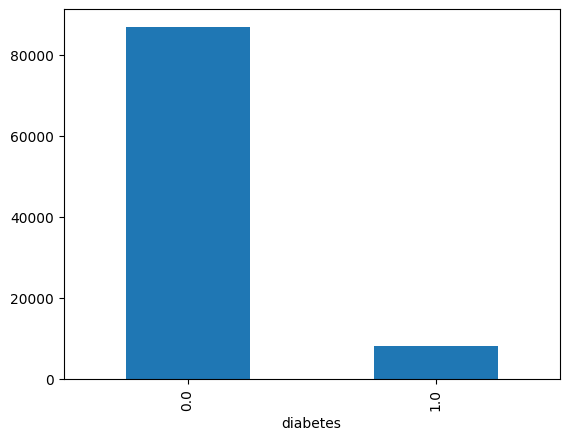

In [8]:
train_df.groupby("patient").diabetes.mean().value_counts().plot(kind='bar')

**¡Clases desbalanceadas!** y que sucede si analizamos genero y edad?

Necesitamos contruir nuestros conjuntos de datos para realizar los entrenamientos:

In [9]:
imputer_cols = ["patient", "age", "hypertension", "heart_disease", "bmi" ,"HbA1c_level", "blood_glucose_level", "diabetes"]
imputer = SimpleImputer(strategy="median")
train_df[imputer_cols] = imputer.fit_transform(train_df[imputer_cols])
y = train_df.diabetes
X = train_df.drop('diabetes',axis=1)
X

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,20432.0,Male,4.0,0.0,0.0,never,19.28,3.5,155.0
1,49682.0,Female,50.0,0.0,0.0,former,27.32,5.7,159.0
2,73886.0,Female,43.0,0.0,0.0,never,21.54,4.5,145.0
3,53144.0,Male,64.0,0.0,0.0,current,28.22,6.0,130.0
4,98507.0,Male,10.0,0.0,0.0,No Info,15.46,6.1,140.0
...,...,...,...,...,...,...,...,...,...
94995,81090.0,Female,56.0,0.0,0.0,never,22.30,6.2,158.0
94996,90924.0,Female,24.0,0.0,0.0,never,22.50,6.1,126.0
94997,64600.0,Female,32.0,0.0,0.0,never,24.92,6.6,145.0
94998,96132.0,Female,21.0,0.0,0.0,current,20.59,4.5,155.0


Vamos a separar la columna con los Id de los pacientes en una sola variable:

In [10]:
patientId = X.patient
X.drop('patient',axis=1,inplace=True)

Necesitamos transformar las variables que son categoricas a númericas, como por ejemplo **gender** y **smoking_history**

In [11]:
print(X.columns)
label_cols = ["gender", "smoking_history"]

for col in label_cols:
    X[col] = X[col].astype(str)
    X[col] = LabelEncoder().fit_transform(X[col])
X

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level'],
      dtype='object')


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,1,4.0,0.0,0.0,4,19.28,3.5,155.0
1,0,50.0,0.0,0.0,3,27.32,5.7,159.0
2,0,43.0,0.0,0.0,4,21.54,4.5,145.0
3,1,64.0,0.0,0.0,1,28.22,6.0,130.0
4,1,10.0,0.0,0.0,0,15.46,6.1,140.0
...,...,...,...,...,...,...,...,...
94995,0,56.0,0.0,0.0,4,22.30,6.2,158.0
94996,0,24.0,0.0,0.0,4,22.50,6.1,126.0
94997,0,32.0,0.0,0.0,4,24.92,6.6,145.0
94998,0,21.0,0.0,0.0,1,20.59,4.5,155.0


Necesitamos también estandarizar las variables:

In [12]:
x_names = X.columns
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns=x_names)
X

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,1.185739,-1.684913,-0.284899,-0.202693,0.961962,-1.213479,-1.894556,0.415552
1,-0.842187,0.358199,-0.284899,-0.202693,0.432680,-0.000133,0.161028,0.513736
2,-0.842187,0.047291,-0.284899,-0.202693,0.961962,-0.872414,-0.960200,0.170091
3,1.185739,0.980016,-0.284899,-0.202693,-0.625885,0.135690,0.441335,-0.198100
4,1.185739,-1.418420,-0.284899,-0.202693,-1.155167,-1.789970,0.534771,0.047361
...,...,...,...,...,...,...,...,...
94995,-0.842187,0.624692,-0.284899,-0.202693,0.961962,-0.757720,0.628206,0.489190
94996,-0.842187,-0.796604,-0.284899,-0.202693,0.961962,-0.727537,0.534771,-0.296284
94997,-0.842187,-0.441280,-0.284899,-0.202693,0.961962,-0.362326,1.001949,0.170091
94998,-0.842187,-0.929850,-0.284899,-0.202693,-0.625885,-1.015782,-0.960200,0.415552


A partir de los datos en las variables `X` e `y` separamos en train y en test:

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state = 8)

### Planteo de modelos
Tienen que elegir los 2 mejores modelos así que prueben con varios.

In [14]:
clfs =  [DecisionTreeClassifier(random_state=8),
        RandomForestClassifier(random_state=8),
        LogisticRegression(random_state=8),
        MLPClassifier(random_state=8),
        XGBClassifier(random_state=8),
        GaussianNB(),
        LinearSVC(random_state=8)]

names = ['Arbol de decisión',
        'Random Forest',
        'Regresión Logística',
        'Perceptrón multicapa',
        'XGBoost',
        'Naive Bayes',
        'SVM']

trained_models = []
accuracy_models = []
for clf,name in zip(clfs,names):
    print(name)
    clf.fit(x_train, y_train)
    train_predictions = clf.predict(x_train)
    accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))

    train_predictions = clf.predict(x_test)
    accuracy = accuracy_score(y_test, train_predictions)
    print("Accuracy test {name}: %.2f%%" % (accuracy * 100.0))
    # plot_confusion_matrix(clf,x_test,y_test)
    trained_models.append(clf)
    accuracy_models.append(accuracy*100)

Arbol de decisión
Accuracy train Arbol de decisión: 99.92%
Accuracy test {name}: 95.02%
Random Forest
Accuracy train Random Forest: 99.92%
Accuracy test {name}: 97.03%
Regresión Logística
Accuracy train Regresión Logística: 96.04%
Accuracy test {name}: 95.97%
Perceptrón multicapa
Accuracy train Perceptrón multicapa: 97.21%
Accuracy test {name}: 97.22%
XGBoost
Accuracy train XGBoost: 97.51%
Accuracy test {name}: 97.23%
Naive Bayes
Accuracy train Naive Bayes: 90.26%
Accuracy test {name}: 90.77%
SVM


c:\Users\jzerda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy train SVM: 96.07%
Accuracy test {name}: 96.02%


c:\Users\jzerda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Algún tipo de ajuste de hiperparámetros de los modelos elegidos

In [15]:
grid = GridSearchCV(DecisionTreeClassifier(),
 {'criterion':('gini','entropy'),
 'splitter':("best","random"),
  'min_samples_leaf':(1, 2, 5),
  'min_samples_split':(2, 3, 5, 10, 50, 100),
 'max_depth':(5,10,20)})
grid.fit(x_train,y_train)
grid.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}

In [16]:
grid_MLPC = GridSearchCV(MLPClassifier(),
 {'solver':('adam','sgd'),
 'alpha':(0.0001,0.0002,0.0005),
  'activation':('identity', 'logistic', 'tanh', 'relu'),
  'learning_rate': ('constant', 'invscaling', 'adaptive'),
  })
grid_MLPC.fit(x_train,y_train)
best_params_MLPC = grid_MLPC.best_params_
best_estimator_MLPC = grid_MLPC.best_estimator_
best_params_MLPC

c:\Users\jzerda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Users\jzerda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
clf_MLPC = best_estimator_MLPC.fit(x_train, y_train)

train_predictions = clf_MLPC.predict(x_train)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train MLPC: %.2f%%" % (accuracy * 100.0))

test_predictions = clf_MLPC.predict(x_test)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test MLPC: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()

print(classification_report(y_test,clf_MLPC.predict(x_test)))

Accuracy train Arbol de decisión: 97.16%
Accuracy test Arbol de decisión: 97.27%


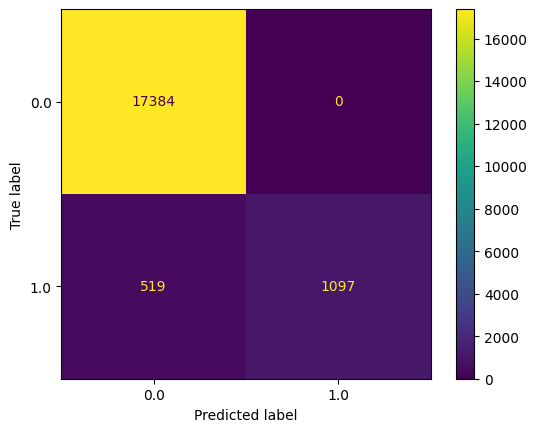

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     17384
         1.0       1.00      0.68      0.81      1616

    accuracy                           0.97     19000
   macro avg       0.99      0.84      0.90     19000
weighted avg       0.97      0.97      0.97     19000



In [31]:
clf = DecisionTreeClassifier(**grid.best_params_).fit(x_train, y_train)

train_predictions = clf.predict(x_train)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train Arbol de decisión: %.2f%%" % (accuracy * 100.0))

test_predictions = clf.predict(x_test)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test Arbol de decisión: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()

print(classification_report(y_test,clf.predict(x_test)))

In [32]:
FOLDS=5
cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=10)

x_train2 = np.array(x_train)
y_train2 = np.array(y_train)


for clfi, name in zip([DecisionTreeClassifier(**grid.best_params_)],names):
    print(clfi)
    avg_accuracy = 0
    for fold, (train_idx, val_idx) in enumerate(cv.split(x_train2, y_train2)):
        xi, yi = x_train2[train_idx], y_train2[train_idx]
        x_valid, y_valid = x_train2[val_idx], y_train2[val_idx]
        clfi = clfi.fit(xi, yi)

        test_predictions = clfi.predict(x_valid)
        accuracy = accuracy_score(y_valid, test_predictions)
        avg_accuracy +=accuracy
        print(f"Precisión test fold {fold}: {accuracy * 100.0 :.2f}" % ())

    avg_accuracy /= FOLDS
    print(f'Avg. accuracy = {avg_accuracy * 100}')

DecisionTreeClassifier(max_depth=5)
Precisión test fold 0: 97.16
Precisión test fold 1: 96.86
Precisión test fold 2: 97.32
Precisión test fold 3: 97.16
Precisión test fold 4: 97.31
Avg. accuracy = 97.16184210526316


## Generar la salida para entregar

In [33]:
test_df = pd.read_csv('diabetes_prediction_dataset_test.csv')


In [34]:
test_df

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,49267,Male,53.0,0,0,never,31.99,4.5,126,NaN
1,82280,Female,22.0,0,0,never,25.96,6.6,130,NaN
2,33216,Female,37.0,0,0,never,22.24,6.2,126,NaN
3,94551,Female,29.0,0,0,not current,31.01,5.0,80,NaN
4,43760,Male,30.0,0,0,ever,28.66,6.6,100,NaN
...,...,...,...,...,...,...,...,...,...,...
4995,88540,Female,23.0,0,0,never,22.77,6.6,200,NaN
4996,26701,Female,51.0,0,0,No Info,27.32,4.0,155,NaN
4997,47271,Male,79.0,0,0,No Info,23.80,6.0,126,NaN
4998,97941,Male,24.0,0,0,never,22.68,6.1,85,NaN


Para poder evaluar nuestra predicción los datos de prueba deben tener exactamente el mismo tratamiento que los datos de entrenamiento

In [35]:
Y_test = test_df.diabetes
PatientId_test = test_df['patient']
X_test = test_df.drop(['patient','diabetes'],axis=1,inplace=True)


In [36]:
X_test = test_df

In [37]:
imputer_cols = ["age", "hypertension", "heart_disease", "bmi" ,"HbA1c_level", "blood_glucose_level"]
imputer = SimpleImputer(strategy="median")
X_test[imputer_cols] = imputer.fit_transform(X_test[imputer_cols])

In [38]:
label_cols = ["gender", "smoking_history"]

for col in label_cols:
    X_test[col] = X_test[col].astype(str)
    X_test[col] = LabelEncoder().fit_transform(X_test[col])
X_test

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,1,53.0,0.0,0.0,4,31.99,4.5,126.0
1,0,22.0,0.0,0.0,4,25.96,6.6,130.0
2,0,37.0,0.0,0.0,4,22.24,6.2,126.0
3,0,29.0,0.0,0.0,5,31.01,5.0,80.0
4,1,30.0,0.0,0.0,2,28.66,6.6,100.0
...,...,...,...,...,...,...,...,...
4995,0,23.0,0.0,0.0,4,22.77,6.6,200.0
4996,0,51.0,0.0,0.0,0,27.32,4.0,155.0
4997,1,79.0,0.0,0.0,0,23.80,6.0,126.0
4998,1,24.0,0.0,0.0,4,22.68,6.1,85.0


In [39]:
cols = X_test.columns
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns=cols)

In [40]:
X_test

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,1.216115,0.534851,-0.275614,-0.200374,0.989602,0.683720,-0.950085,-0.294803
1,-0.819565,-0.840774,-0.275614,-0.200374,0.989602,-0.198857,0.997153,-0.195048
2,-0.819565,-0.175149,-0.275614,-0.200374,0.989602,-0.743333,0.626250,-0.294803
3,-0.819565,-0.530149,-0.275614,-0.200374,1.517446,0.540283,-0.486457,-1.441995
4,1.216115,-0.485774,-0.275614,-0.200374,-0.066086,0.196327,0.997153,-0.943216
...,...,...,...,...,...,...,...,...
4995,-0.819565,-0.796399,-0.275614,-0.200374,0.989602,-0.665760,0.997153,1.550679
4996,-0.819565,0.446101,-0.275614,-0.200374,-1.121774,0.000198,-1.413713,0.428426
4997,1.216115,1.688601,-0.275614,-0.200374,-1.121774,-0.515004,0.440799,-0.294803
4998,1.216115,-0.752024,-0.275614,-0.200374,0.989602,-0.678933,0.533525,-1.317300


Generamos la salida

In [41]:
test_id = PatientId_test
test_pred = np.int64(clf.predict(X_test))

Con el resultado predicho tenemos que generar el archivo `.csv` para subir a la competencia de kaggle:

In [42]:
submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["patient", "diabetes"])
submission.to_csv("sample_submission.csv", header=True, index=False)

**Suerte!! :D**